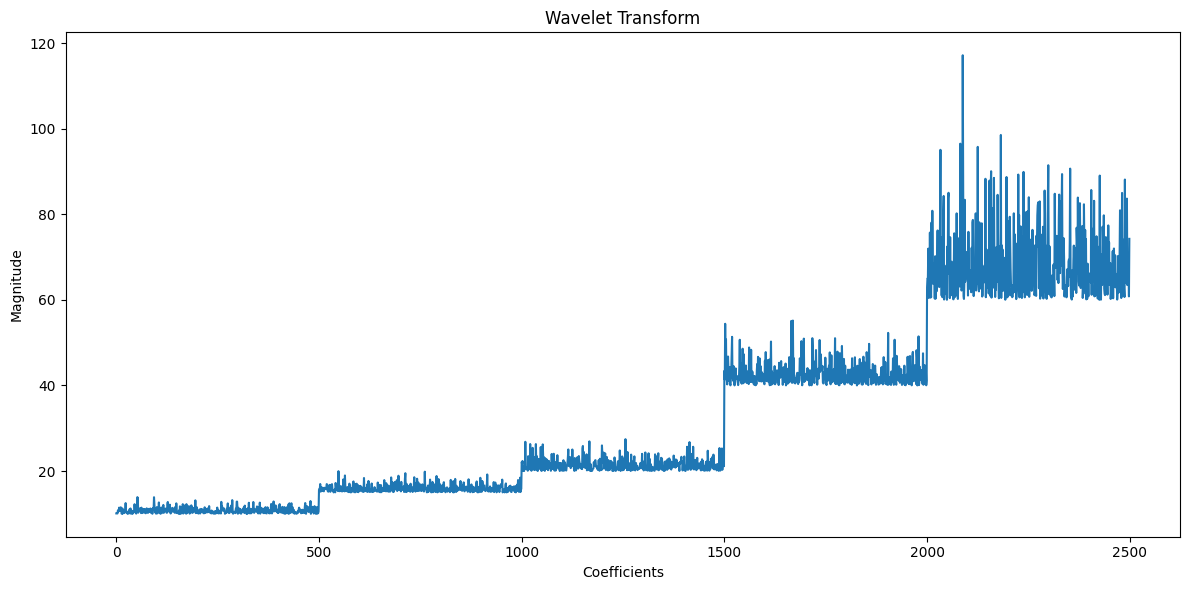

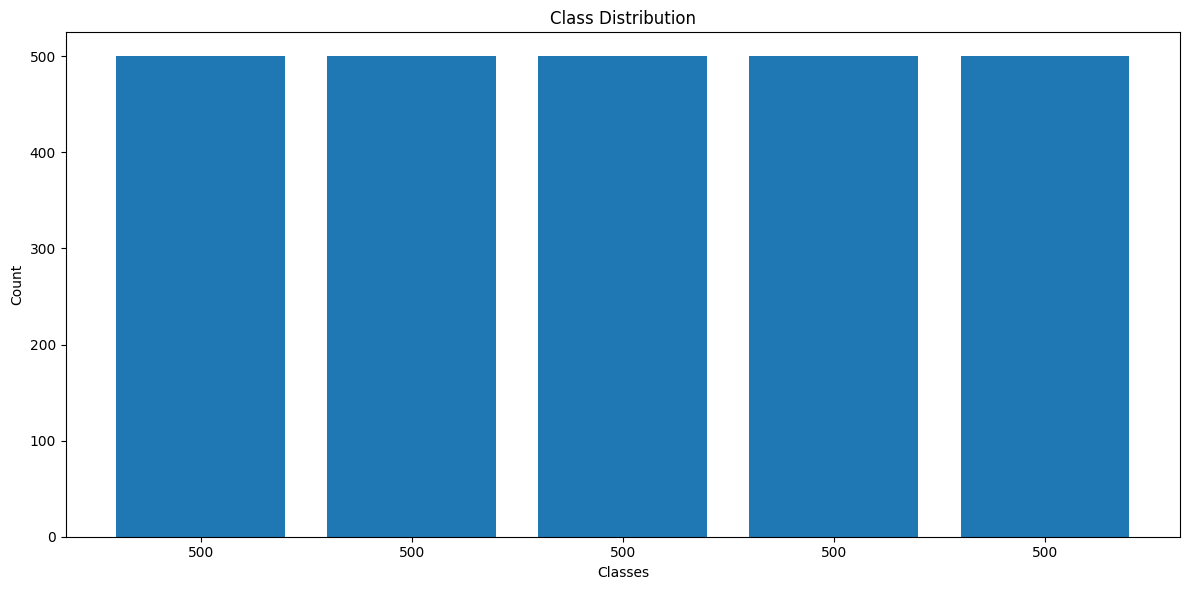

Evaluation Metrics:
Accuracy: 0.7384
F1 Score: 0.7204127298869348
Precision: 0.729692725695387
Recall: 0.7384

Confusion Matrix:
[[205   0  37  16   0]
 [  0 247   0   0   9]
 [179   0  40  21   0]
 [ 24   0  38 190   3]
 [  0   0   0   0 241]]

Classification Report:
Class b'New' - Precision: 0.50, Recall: 0.79, F1-score: 0.62
Class b'Severe' - Precision: 1.00, Recall: 0.96, F1-score: 0.98
Class b'Slightly' - Precision: 0.35, Recall: 0.17, F1-score: 0.23
Class b'Working' - Precision: 0.84, Recall: 0.75, F1-score: 0.79
Class b'Wornout' - Precision: 0.95, Recall: 1.00, F1-score: 0.98


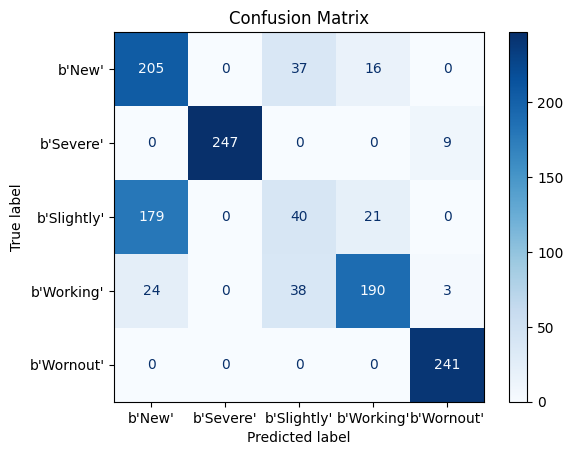


Initial state distribution:
[0.00000e+000 0.00000e+000 0.00000e+000 0.00000e+000 3.17393e-319
 0.00000e+000 0.00000e+000 0.00000e+000 0.00000e+000 0.00000e+000
 0.00000e+000 0.00000e+000 0.00000e+000 0.00000e+000 0.00000e+000
 0.00000e+000 0.00000e+000 0.00000e+000 0.00000e+000 0.00000e+000
 0.00000e+000 0.00000e+000 0.00000e+000 0.00000e+000 0.00000e+000
 1.00000e+000 0.00000e+000 0.00000e+000 0.00000e+000 0.00000e+000]

Transition matrix:
[[7.77278327e-030 3.69011388e-001 1.36203929e-220 4.55298376e-040
  3.85131657e-041 1.14221253e-028 1.32447081e-080 1.35128804e-017
  2.84891161e-067 8.62974397e-269 0.00000000e+000 3.12690356e-018
  1.47257678e-033 4.82112821e-025 2.24840284e-067 2.23244435e-059
  4.81128016e-001 3.62787974e-030 1.02504631e-044 2.27178496e-061
  3.21459664e-085 2.59604920e-036 5.25156039e-004 1.38884693e-065
  1.34010633e-029 3.99953699e-087 1.49335440e-001 1.13910923e-063
  7.82551162e-013 9.26918033e-021]
 [6.83460649e-009 3.74761776e-042 0.00000000e+000 4.22134

In [188]:
import h5py
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from hmmlearn import hmm
np.random.seed(42)

def flat_wavelet_transform2(data, method):
    """For a 1D or 2D image data, take the wavelet transform"""
    if data.ndim == 1:
        data = data.reshape(1, -1)  # Reshape 1D data to 2D
    coeffs = pywt.wavedec2(data, method)
    output = coeffs[0].reshape(-1)
    for tups in coeffs[1:]:
        for c in tups:
            output = np.concatenate((output, c.reshape(-1)))
    return output

def plot_wavelet_transform(transformed_data, classes):
    plt.figure(figsize=(12, 6))
    plt.plot(transformed_data)
    plt.title('Wavelet Transform')
    plt.xlabel('Coefficients')
    plt.ylabel('Magnitude')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    indices = np.arange(len(classes))
    plt.bar(indices, classes)
    plt.xticks(indices, classes)
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

def train_hmm_model(train_sequences, n_states):
    """Train the HMM model."""
    hmm_model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=150)
    hmm_model.fit(train_sequences)
    return hmm_model

def evaluate_hmm_model(hmm_model, test_sequences, test_labels):
    """Evaluate the HMM model."""
    hidden_state_sequences = hmm_model.predict(test_sequences)

    # Ensure test_labels is a 1D array
    test_labels = np.asarray(test_labels).ravel()  # Flatten in case it's not 1D

    # Map hidden states to most frequent labels
    state_to_label_map = {}
    for state in np.unique(hidden_state_sequences):
        mask = hidden_state_sequences == state
        if np.any(mask):  # Check if mask has any True values
            most_frequent_label = np.bincount(test_labels[mask]).argmax()
            state_to_label_map[state] = most_frequent_label

    predicted_labels = np.array([state_to_label_map.get(state, -1) for state in hidden_state_sequences])

    # Calculate metrics
    accuracy = accuracy_score(test_labels, predicted_labels)
    f1 = f1_score(test_labels, predicted_labels, average='weighted', zero_division=0)
    precision = precision_score(test_labels, predicted_labels, average='weighted', zero_division=0)
    recall = recall_score(test_labels, predicted_labels, average='weighted', zero_division=0)
    cm = confusion_matrix(test_labels, predicted_labels)

    return accuracy, f1, precision, recall, cm

def print_evaluation_results(accuracy, f1, precision, recall, cm, class_names):
    """Print evaluation results."""
    print("Evaluation Metrics:")
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Precision:", precision)
    print("Recall:", recall)

    # Print the confusion matrix
    print("\nConfusion Matrix:")
    print(cm)

    # Print the classification report
    print("\nClassification Report:")
    for i in range(len(class_names)):
        precision = cm[i, i] / np.sum(cm[:, i]) if np.sum(cm[:, i]) != 0 else 0.0
        recall = cm[i, i] / np.sum(cm[i, :]) if np.sum(cm[i, :]) != 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0
        print(f"Class {class_names[i]} - Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

if __name__ == "__main__":
    # Load the dataset
    with h5py.File(r"M:\E-books\ML_project\Accepted_dataset.h5") as file:
        soundpressure = file['InputFeatures']['SoundPressure'][:]     
        condition = file['TargetLabels']['target'][:] 

    # Wavelet transform
    methods = ['haar', 'coif1', 'coif2', 'coif3', 'bior1.1', 'bior1.3', 'bior3.1', 'bior3.3', 'rbio1.1', 'rbio1.3', 'rbio3.1', 'rbio3.3']
    transformed_data = flat_wavelet_transform2(soundpressure, 'sym2')

    # Plotting
    condition = pd.DataFrame(condition, columns=['target'])
    label_encoder = LabelEncoder()
    condition['target'] = label_encoder.fit_transform(condition['target'])
    transformed_data = pd.DataFrame(transformed_data, columns=['value'])

    plot_wavelet_transform(transformed_data['value'].values, condition['target'].value_counts().values)

    # Prepare data for HMM
    X_train, X_test, y_train, y_test = train_test_split(transformed_data.values, condition['target'].values, test_size=0.5, random_state=42)
    
    n_states = 30  # Number of hidden states based on unique labels
    hmm_model = train_hmm_model(X_train, n_states)

    # Evaluate the model
    accuracy, f1, precision, recall, cm = evaluate_hmm_model(hmm_model, X_test, y_test)

    # Print evaluation results
    class_names = label_encoder.classes_  # Get original class names
    print_evaluation_results(accuracy, f1, precision, recall, cm, class_names)

    # Print learned parameters
    print("\nInitial state distribution:")
    print(hmm_model.startprob_)
    print("\nTransition matrix:")
    print(hmm_model.transmat_)
    print("\nMeans and covariances of the emission distributions:")
    print("Means:")
    print(hmm_model.means_)
    print("\nCovariances:")
    print(hmm_model.covars_)


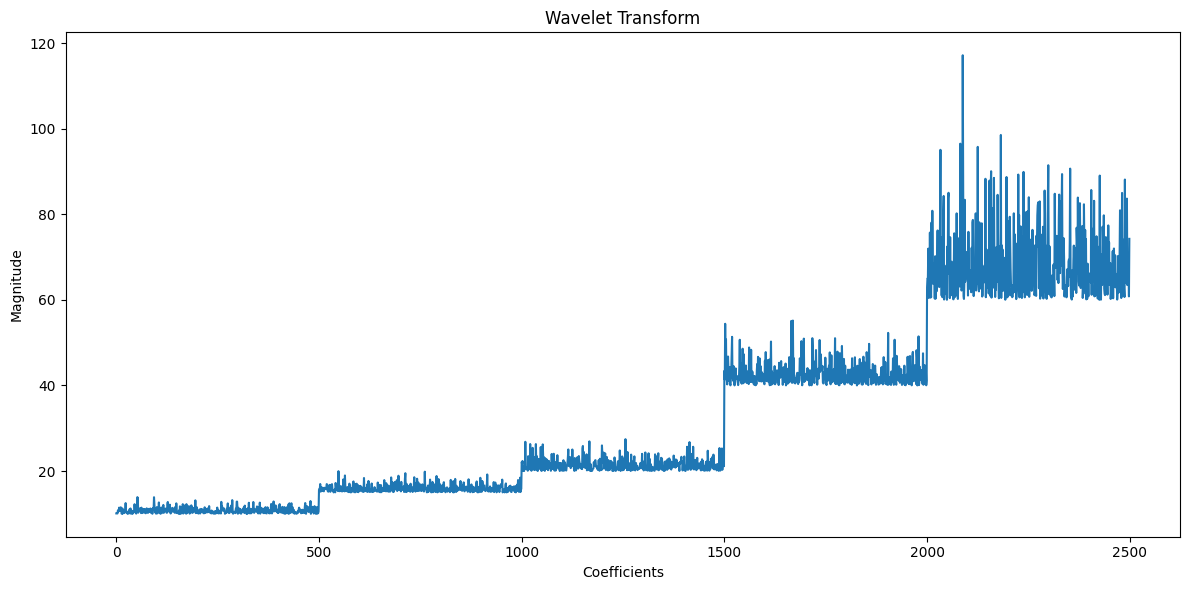

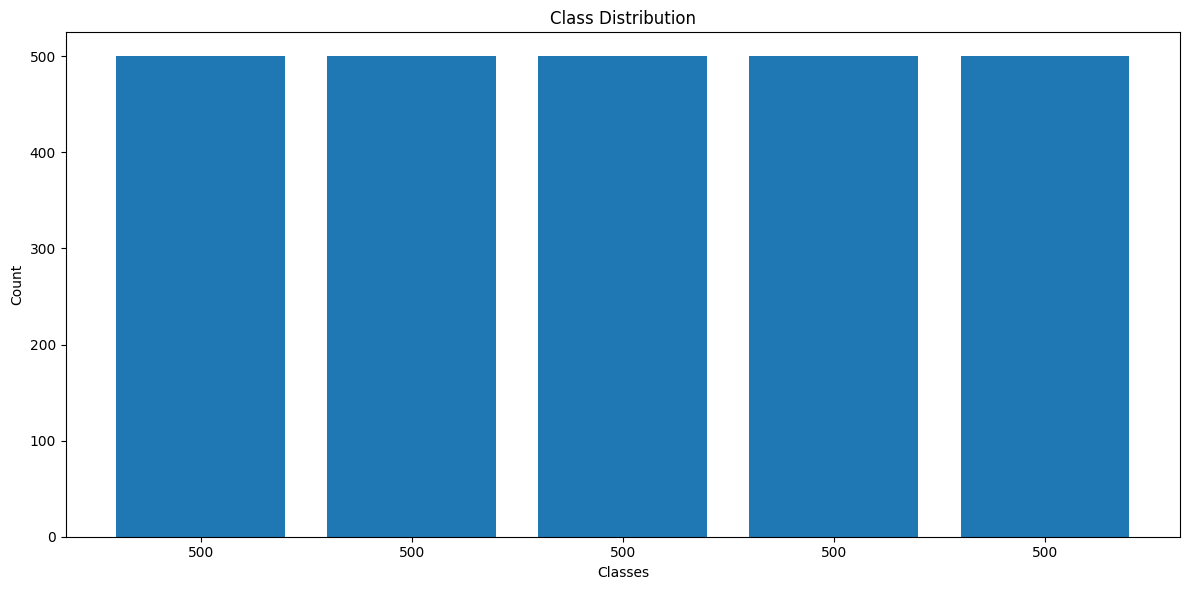

Training HMM with 2 states...
Training HMM with 3 states...
Training HMM with 4 states...
Training HMM with 5 states...
Training HMM with 6 states...
Training HMM with 7 states...
Training HMM with 8 states...
Training HMM with 9 states...
Training HMM with 10 states...
Training HMM with 11 states...
Training HMM with 12 states...
Training HMM with 13 states...
Training HMM with 14 states...
Training HMM with 15 states...
Training HMM with 16 states...
Training HMM with 17 states...
Training HMM with 18 states...
Training HMM with 19 states...
Training HMM with 20 states...
Training HMM with 21 states...
Training HMM with 22 states...
Training HMM with 23 states...
Training HMM with 24 states...
Training HMM with 25 states...
Training HMM with 26 states...
Training HMM with 27 states...
Training HMM with 28 states...
Training HMM with 29 states...
Training HMM with 30 states...
Training HMM with 31 states...
Training HMM with 32 states...
Training HMM with 33 states...
Training HMM wit

Fitting a model with 1294 free scalar parameters with only 1250 data points will result in a degenerate solution.


Training HMM with 35 states...


Fitting a model with 1367 free scalar parameters with only 1250 data points will result in a degenerate solution.


Training HMM with 36 states...


Fitting a model with 1442 free scalar parameters with only 1250 data points will result in a degenerate solution.


Training HMM with 37 states...


Fitting a model with 1519 free scalar parameters with only 1250 data points will result in a degenerate solution.


Training HMM with 38 states...


Fitting a model with 1598 free scalar parameters with only 1250 data points will result in a degenerate solution.


Training HMM with 39 states...


Fitting a model with 1679 free scalar parameters with only 1250 data points will result in a degenerate solution.


Training HMM with 40 states...


Fitting a model with 1762 free scalar parameters with only 1250 data points will result in a degenerate solution.


Training HMM with 41 states...


Fitting a model with 1847 free scalar parameters with only 1250 data points will result in a degenerate solution.


Training HMM with 42 states...


Fitting a model with 1934 free scalar parameters with only 1250 data points will result in a degenerate solution.


Training HMM with 43 states...


Fitting a model with 2023 free scalar parameters with only 1250 data points will result in a degenerate solution.


Training HMM with 44 states...


Fitting a model with 2114 free scalar parameters with only 1250 data points will result in a degenerate solution.


Training HMM with 45 states...


Fitting a model with 2207 free scalar parameters with only 1250 data points will result in a degenerate solution.


Training HMM with 46 states...


Fitting a model with 2302 free scalar parameters with only 1250 data points will result in a degenerate solution.


Training HMM with 47 states...


Fitting a model with 2399 free scalar parameters with only 1250 data points will result in a degenerate solution.


Training HMM with 48 states...


Fitting a model with 2498 free scalar parameters with only 1250 data points will result in a degenerate solution.


Training HMM with 49 states...


Fitting a model with 2599 free scalar parameters with only 1250 data points will result in a degenerate solution.


Training HMM with 50 states...
Best Model Performance with 20 states:
Evaluation Metrics:
Accuracy: 0.9416
F1 Score: 0.9425504186728145
Precision: 0.9489463314794215
Recall: 0.9416

Confusion Matrix:
[[237   0  21   0   0]
 [  0 247   0   0   9]
 [  0   0 234   6   0]
 [  0   0  35 219   1]
 [  0   1   0   0 240]]

Classification Report:
Class b'New' - Precision: 1.00, Recall: 0.92, F1-score: 0.96
Class b'Severe' - Precision: 1.00, Recall: 0.96, F1-score: 0.98
Class b'Slightly' - Precision: 0.81, Recall: 0.97, F1-score: 0.88
Class b'Working' - Precision: 0.97, Recall: 0.86, F1-score: 0.91
Class b'Wornout' - Precision: 0.96, Recall: 1.00, F1-score: 0.98


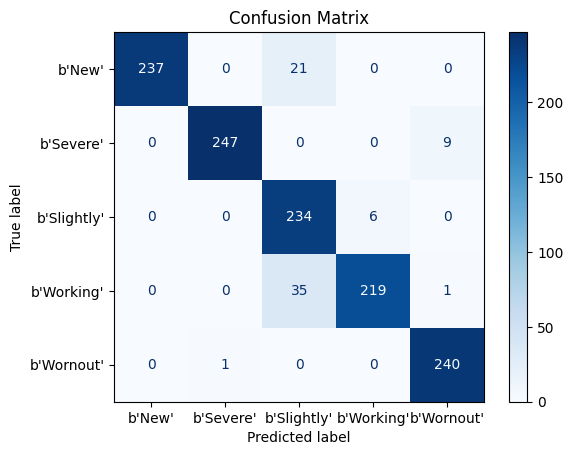


Best Model Parameters:

Initial state distribution:
[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 5.32547009e-171 2.28038024e-232 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 1.00000000e+000]

Transition matrix:
[[1.99436015e-001 1.15808265e-012 1.26201166e-017 1.11662143e-001
  4.84374277e-002 1.35550711e-001 1.84212827e-002 5.32508382e-002
  2.36786521e-002 6.21466589e-002 5.91716252e-003 1.51009518e-002
  7.64673722e-015 0.00000000e+000 1.49481549e-001 4.43794651e-015
  3.57389120e-040 3.86741883e-023 1.73074140e-001 3.84246912e-003]
 [2.22321779e-001 1.68979446e-067 0.00000000e+000 3.55319389e-054
  8.97759161e-032 1.63124369e-001 2.78644368e-016 1.04477366e-001
  1.98411748e-001 1.41932123e-040 2.64615714e-015 5.24904849e-226
  5.89008158e-002 0.00000000e+000 3.21666572e-018 2.17759355e-090
  3.95

In [189]:
if __name__ == "__main__":
    # Load the dataset
    with h5py.File(r"M:\E-books\ML_project\Accepted_dataset.h5") as file:
        soundpressure = file['InputFeatures']['SoundPressure'][:]     
        condition = file['TargetLabels']['target'][:] 

    # Wavelet transform
    methods = ['haar', 'coif1', 'coif2', 'coif3', 'bior1.1', 'bior1.3', 'bior3.1', 'bior3.3', 'rbio1.1', 'rbio1.3', 'rbio3.1', 'rbio3.3']
    transformed_data = flat_wavelet_transform2(soundpressure, 'sym2')

    # Plotting
    condition = pd.DataFrame(condition, columns=['target'])
    label_encoder = LabelEncoder()
    condition['target'] = label_encoder.fit_transform(condition['target'])
    transformed_data = pd.DataFrame(transformed_data, columns=['value'])

    plot_wavelet_transform(transformed_data['value'].values, condition['target'].value_counts().values)

    # Prepare data for HMM
    X_train, X_test, y_train, y_test = train_test_split(transformed_data.values, condition['target'].values, test_size=0.5, random_state=42)

    # Iterate over different n_states
    best_accuracy = 0
    best_f1 = 0
    best_precision = 0
    best_recall = 0
    best_cm = None
    best_n_states = 0
    best_model = None

    for n_states in range(2, 51):  # You can adjust the range as needed
        print(f"Training HMM with {n_states} states...")
        hmm_model = train_hmm_model(X_train, n_states)

        # Evaluate the model
        accuracy, f1, precision, recall, cm = evaluate_hmm_model(hmm_model, X_test, y_test)

        # Check for best model based on F1 Score
        if f1 > best_f1:
            best_f1 = f1
            best_accuracy = accuracy
            best_precision = precision
            best_recall = recall
            best_cm = cm
            best_n_states = n_states
            best_model = hmm_model

    # Print best evaluation results
    print(f"Best Model Performance with {best_n_states} states:")
    print_evaluation_results(best_accuracy, best_f1, best_precision, best_recall, best_cm, label_encoder.classes_)

    # Print learned parameters for the best model
    print("\nBest Model Parameters:")
    print("\nInitial state distribution:")
    print(best_model.startprob_)
    print("\nTransition matrix:")
    print(best_model.transmat_)
    print("\nMeans and covariances of the emission distributions:")
    print("Means:")
    print(best_model.means_)
    print("\nCovariances:")
    print(best_model.covars_)


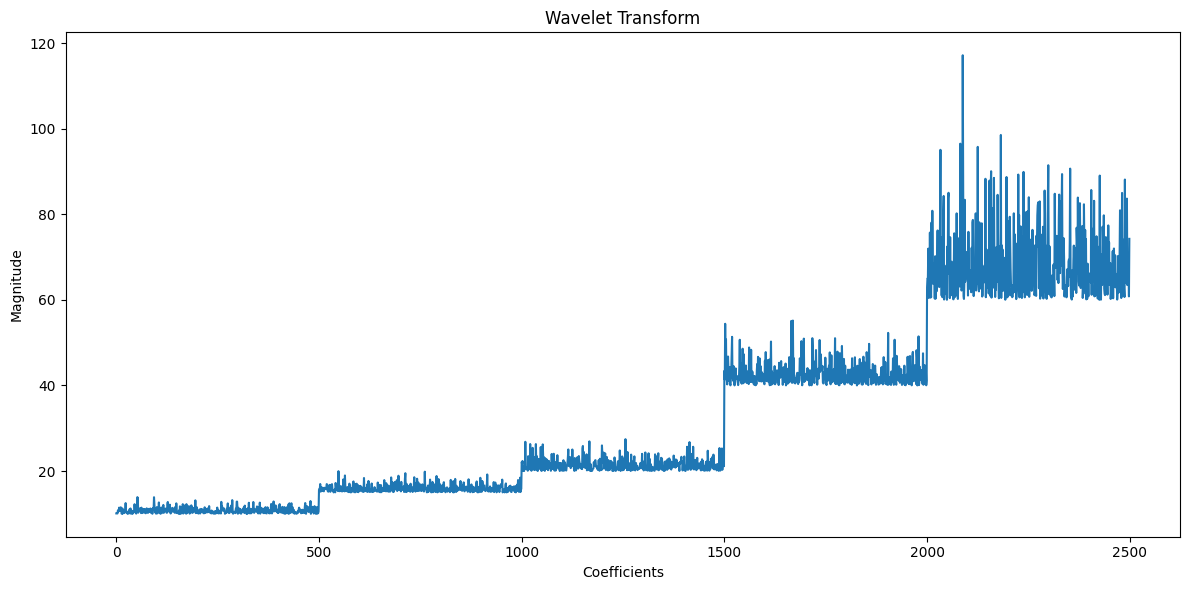

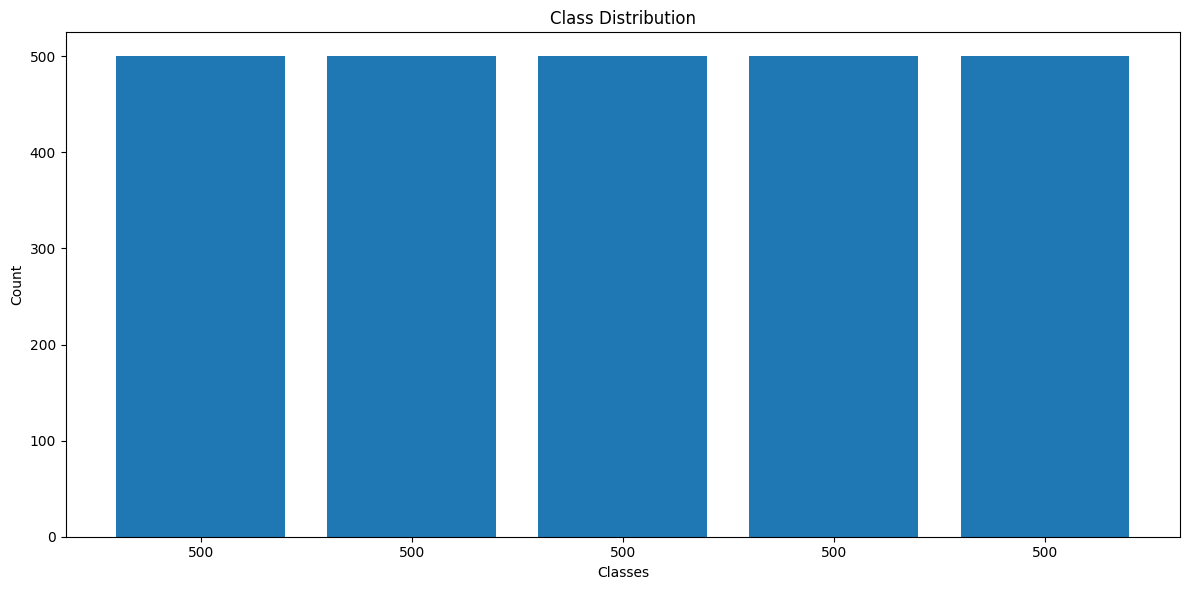

Training HMM with 2 states...
Training HMM with 3 states...
Training HMM with 4 states...
Training HMM with 5 states...
Training HMM with 6 states...
Training HMM with 7 states...
Training HMM with 8 states...
Training HMM with 9 states...
Training HMM with 10 states...
Training HMM with 11 states...
Training HMM with 12 states...
Training HMM with 13 states...
Training HMM with 14 states...
Training HMM with 15 states...
Training HMM with 16 states...
Training HMM with 17 states...
Training HMM with 18 states...
Training HMM with 19 states...
Training HMM with 20 states...
Training HMM with 21 states...
Training HMM with 22 states...
Training HMM with 23 states...
Training HMM with 24 states...
Training HMM with 25 states...
Training HMM with 26 states...
Training HMM with 27 states...
Training HMM with 28 states...
Training HMM with 29 states...
Training HMM with 30 states...
Training HMM with 31 states...
Training HMM with 32 states...
Training HMM with 33 states...
Training HMM wit

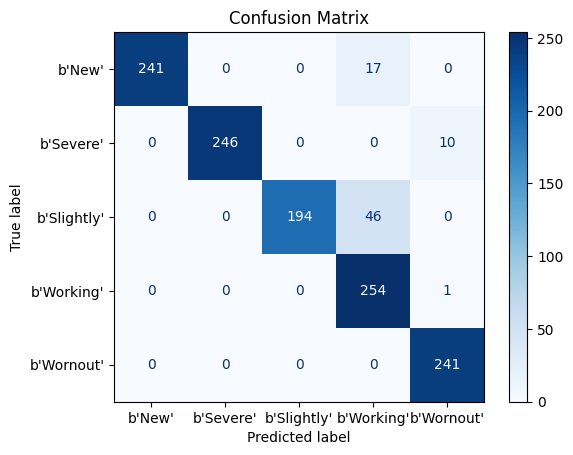


Best Model Parameters:

Initial state distribution:
[0.00000000e+000 5.53598979e-243 0.00000000e+000 6.72565921e-022
 0.00000000e+000 0.00000000e+000 1.00000000e+000 0.00000000e+000
 6.21949240e-247 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 1.04199596e-105]

Transition matrix:
[[2.32654026e-001 7.41121945e-002 3.70494444e-001 3.38672534e-010
  1.37442095e-001 3.30834630e-011 8.81020537e-017 8.85780945e-008
  4.60738571e-002 1.55403623e-109 3.06924206e-016 4.10993213e-014
  1.10129186e-001 2.90941087e-002 4.24767704e-041 8.95938445e-015]
 [8.22622565e-028 1.68701752e-042 4.21611321e-010 1.05389383e-001
  3.47556254e-021 4.03437166e-006 3.03755601e-001 7.16712670e-030
  4.67486941e-034 1.58355288e-124 4.89423827e-001 1.08512668e-018
  6.08455417e-020 1.07462165e-029 5.37989105e-002 4.76282433e-002]
 [8.19744898e-005 2.52132475e-014 5.79764228e-002 1.35800014e-021
  1.71267447e-001 2.42060375e-001 9.48751832e-002 1.30839670e-026
  6.

In [190]:
if __name__ == "__main__":
    # Load the dataset
    with h5py.File(r"M:\E-books\ML_project\Accepted_dataset.h5") as file:
        soundpressure = file['InputFeatures']['SoundPressure'][:]     
        condition = file['TargetLabels']['target'][:] 

    # Wavelet transform
    methods = ['haar', 'coif1', 'coif2', 'coif3', 'bior1.1', 'bior1.3', 'bior3.1', 'bior3.3', 'rbio1.1', 'rbio1.3', 'rbio3.1', 'rbio3.3']
    transformed_data = flat_wavelet_transform2(soundpressure, 'haar')

    # Plotting
    condition = pd.DataFrame(condition, columns=['target'])
    label_encoder = LabelEncoder()
    condition['target'] = label_encoder.fit_transform(condition['target'])
    transformed_data = pd.DataFrame(transformed_data, columns=['value'])

    plot_wavelet_transform(transformed_data['value'].values, condition['target'].value_counts().values)

    # Prepare data for HMM
    X_train, X_test, y_train, y_test = train_test_split(transformed_data.values, condition['target'].values, test_size=0.5, random_state=42)

    # Iterate over different n_states
    best_accuracy = 0
    best_f1 = 0
    best_precision = 0
    best_recall = 0
    best_cm = None
    best_n_states = 0
    best_model = None

    for n_states in range(2,35):  # You can adjust the range as needed
        print(f"Training HMM with {n_states} states...")
        hmm_model = train_hmm_model(X_train, n_states)

        # Evaluate the model
        accuracy, f1, precision, recall, cm = evaluate_hmm_model(hmm_model, X_test, y_test)

        # Check for best model based on F1 Score
        if f1 > best_f1:
            best_f1 = f1
            best_accuracy = accuracy
            best_precision = precision
            best_recall = recall
            best_cm = cm
            best_n_states = n_states
            best_model = hmm_model

    # Print best evaluation results
    print(f"Best Model Performance with {best_n_states} states:")
    print_evaluation_results(best_accuracy, best_f1, best_precision, best_recall, best_cm, label_encoder.classes_)

    # Print learned parameters for the best model
    print("\nBest Model Parameters:")
    print("\nInitial state distribution:")
    print(best_model.startprob_)
    print("\nTransition matrix:")
    print(best_model.transmat_)
    print("\nMeans and covariances of the emission distributions:")
    print("Means:")
    print(best_model.means_)
    print("\nCovariances:")
    print(best_model.covars_)


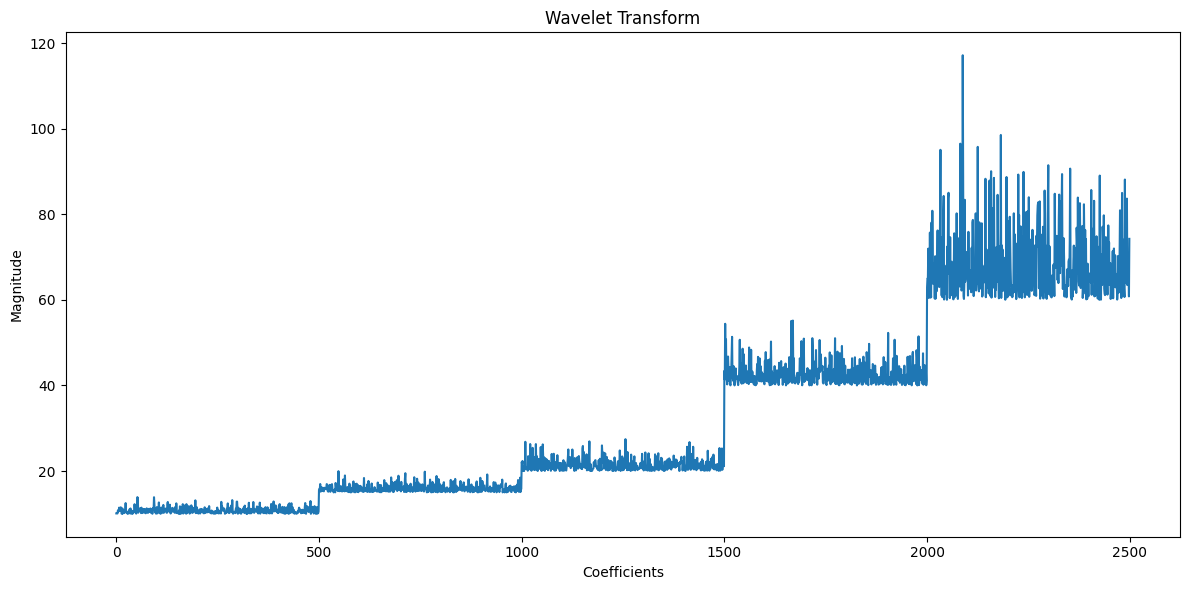

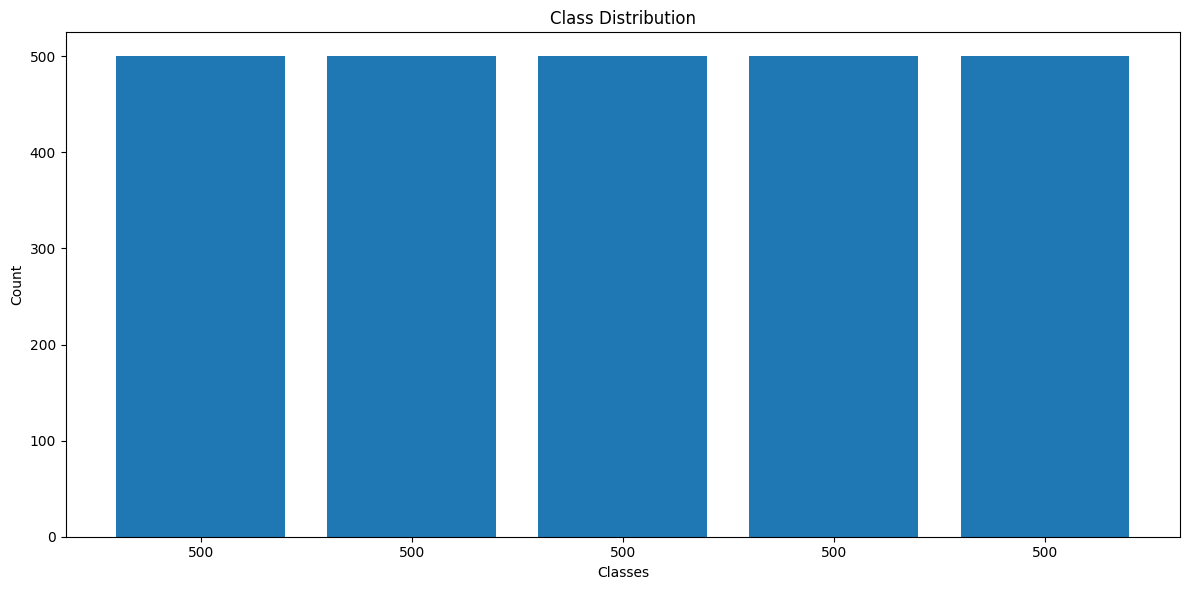

Training HMM with 2 states...
Training HMM with 3 states...
Training HMM with 4 states...
Training HMM with 5 states...
Training HMM with 6 states...
Training HMM with 7 states...
Training HMM with 8 states...
Training HMM with 9 states...
Training HMM with 10 states...
Training HMM with 11 states...
Training HMM with 12 states...
Training HMM with 13 states...
Training HMM with 14 states...
Training HMM with 15 states...
Training HMM with 16 states...
Training HMM with 17 states...
Training HMM with 18 states...
Training HMM with 19 states...
Training HMM with 20 states...
Training HMM with 21 states...
Training HMM with 22 states...
Training HMM with 23 states...
Training HMM with 24 states...
Training HMM with 25 states...
Training HMM with 26 states...
Training HMM with 27 states...
Training HMM with 28 states...
Training HMM with 29 states...
Training HMM with 30 states...
Training HMM with 31 states...
Training HMM with 32 states...
Training HMM with 33 states...
Training HMM wit

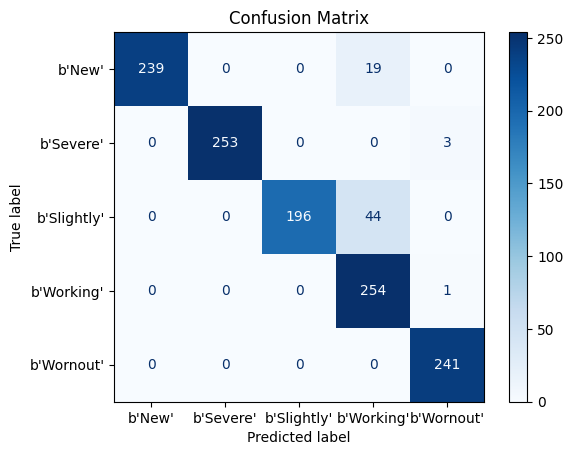


Best Model Parameters:

Initial state distribution:
[0.00000000e+000 0.00000000e+000 3.73308673e-197 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 3.37417103e-190 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 1.00000000e+000]

Transition matrix:
[[7.50722418e-002 1.47621368e-001 9.22897928e-002 1.35105035e-001
  1.18091107e-001 0.00000000e+000 4.43566587e-004 1.24757408e-023
  0.00000000e+000 1.00189065e-036 5.12296777e-002 3.10823322e-023
  7.14632793e-003 1.94854652e-001 1.47591646e-007 7.89498088e-016
  1.78146084e-001 1.46712416e-022]
 [1.22409642e-001 1.78378595e-001 5.82694046e-002 1.39024185e-002
  1.01626806e-001 2.38421480e-003 1.46170103e-001 4.79657567e-002
  0.00000000e+000 9.98356128e-003 2.47651433e-014 2.52422382e-002
  1.31103719e-018 2.64517557e-003 1.29208352e-014 2.90815364e-002
  2.11156230e-001 5.07843177e-002]
 [2.30381978e-008 2.10646099e-001 1

In [191]:
if __name__ == "__main__":
    # Load the dataset
    with h5py.File(r"M:\E-books\ML_project\Accepted_dataset.h5") as file:
        soundpressure = file['InputFeatures']['SoundPressure'][:]     
        condition = file['TargetLabels']['target'][:] 

    # Wavelet transform
    methods = ['haar', 'coif1', 'coif2', 'coif3', 'bior1.1', 'bior1.3', 'bior3.1', 'bior3.3', 'rbio1.1', 'rbio1.3', 'rbio3.1', 'rbio3.3']
    transformed_data = flat_wavelet_transform2(soundpressure, 'db4')

    # Plotting
    condition = pd.DataFrame(condition, columns=['target'])
    label_encoder = LabelEncoder()
    condition['target'] = label_encoder.fit_transform(condition['target'])
    transformed_data = pd.DataFrame(transformed_data, columns=['value'])

    plot_wavelet_transform(transformed_data['value'].values, condition['target'].value_counts().values)

    # Prepare data for HMM
    X_train, X_test, y_train, y_test = train_test_split(transformed_data.values, condition['target'].values, test_size=0.5, random_state=42)

    # Iterate over different n_states
    best_accuracy = 0
    best_f1 = 0
    best_precision = 0
    best_recall = 0
    best_cm = None
    best_n_states = 0
    best_model = None

    for n_states in range(2,35):  # You can adjust the range as needed
        print(f"Training HMM with {n_states} states...")
        hmm_model = train_hmm_model(X_train, n_states)

        # Evaluate the model
        accuracy, f1, precision, recall, cm = evaluate_hmm_model(hmm_model, X_test, y_test)

        # Check for best model based on F1 Score
        if f1 > best_f1:
            best_f1 = f1
            best_accuracy = accuracy
            best_precision = precision
            best_recall = recall
            best_cm = cm
            best_n_states = n_states
            best_model = hmm_model

    # Print best evaluation results
    print(f"Best Model Performance with {best_n_states} states:")
    print_evaluation_results(best_accuracy, best_f1, best_precision, best_recall, best_cm, label_encoder.classes_)

    # Print learned parameters for the best model
    print("\nBest Model Parameters:")
    print("\nInitial state distribution:")
    print(best_model.startprob_)
    print("\nTransition matrix:")
    print(best_model.transmat_)
    print("\nMeans and covariances of the emission distributions:")
    print("Means:")
    print(best_model.means_)
    print("\nCovariances:")
    print(best_model.covars_)
